### Import Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
import seaborn as sns

###  1. Read Data

In [69]:
df_raw = pd.read_table('../data/000_sample1.gz',
                       compression='gzip',
                       sep='\t',
                       quotechar='"',
                       error_bad_lines=False)
df_raw.columns

Skipping line 5749513: expected 26 fields, saw 27



Index([u'advertiser_app_store_id', u'country_code', u'city', u'campaign_id',
       u'creative_id', u'device_language', u'device_make', u'device_model',
       u'device_platform', u'device_connection', u'device_os_version',
       u'device_screen_height', u'device_screen_width', u'device_volume',
       u'event_id', u'n_campaign_views', u'n_vungle_installs',
       u'publisher_app_store_id', u'time_of_last_delivery_this_campaign',
       u'time_of_last_delivery_this_creative',
       u'time_of_last_delivery_any_installed_app',
       u'time_of_last_vungle_delivery', u'time_of_this_impression',
       u'timestamp_at_install', u'time_of_this_request', u'time_zone'],
      dtype='object')

In [11]:
df_raw.iloc[:,1:9].head()

,country_code,city,campaign_id,creative_id,device_language,device_make,device_model,device_platform
0,US,NaN,588773c7eaf745ff5f000224,5860bace91bcf915650001e9,en,Yifang,NXA8QC116,android
1,CO,NaN,58080e334f550f252900005e,5885c28e862f2b7317000205,es,iPhone6,1,iOS
2,KR,NaN,588709603511998624000044,58885b4364f6e6cb700003ee,ko,samsung,SHV-E300S,android
3,US,NaN,57d8ad592767a9fc6b000021,583ad4056c1bbcd212000094,en,Alco,RCT6773W22B,android
4,PH,NaN,58878f7a8dae14b54a0000bd,58878a4ba28050056f0000be,en,Sony,D2502,android


In [14]:
df_raw.iloc[:,9:19].head()

,device_connection,device_os_version,device_screen_height,device_screen_width,device_volume,event_id,n_campaign_views,n_vungle_installs,publisher_app_store_id,time_of_last_delivery_this_campaign
0,wifi,5.1.1,752.0,1280.0,0.533333,588907a201be0e73444d082a,0,1.0,556f7506790e4e9f32000181,NaN
1,wifi,10.2,640.0,1136.0,1.000000,588a7564a071c1214e490f6d,3,0.0,56a1169c2ef5591f35000023,2017-01-25 18:40:07
2,wifi,5.0.1,1080.0,1920.0,0.000000,588a8d3b508daa5e5ddb3905,1,0.0,576c95f871edf0ea54000010,2017-01-26 04:05:36
3,wifi,5.0,976.0,600.0,0.000000,588a8ac8376b155f5f91ff5d,1,0.0,583c56b7c3e0af130a000085,2017-01-24 17:56:34
4,wifi,5.1.1,1208.0,720.0,0.000000,588a8b356011620042d3d418,0,0.0,com.fgol.HungrySharkEvolution,NaN


In [16]:
df_raw.iloc[:,19:].head()

,time_of_last_delivery_this_creative,time_of_last_delivery_any_installed_app,time_of_last_vungle_delivery,time_of_this_impression,timestamp_at_install,time_of_this_request,time_zone
0,NaN,2017-01-22 07:23:31,2017-01-23 00:42:36,2017-01-27 00:00:00,NaN,2017-01-25 20:16:35,America/New_York
1,NaN,NaN,2017-01-26 22:12:34,2017-01-27 00:00:00,NaN,2017-01-26 22:17:07,America/Bogota
2,NaN,NaN,2017-01-26 21:45:17,2017-01-27 00:00:00,NaN,2017-01-26 23:58:57,Asia/Seoul
3,2017-01-24 17:56:34,NaN,2017-01-26 23:45:44,2017-01-27 00:00:00,NaN,2017-01-26 23:48:29,America/New_York
4,NaN,NaN,2017-01-26 14:11:17,2017-01-27 00:00:00,NaN,2017-01-26 23:50:18,Asia/Manila


### 2. Add Y & Clean Data

In [70]:
df_raw['is_install'] = df_raw['timestamp_at_install'].notnull() * 1
df_raw.groupby('is_install').size()

is_install
0    5829475
1    1246965
dtype: int64

In [71]:
df_raw['device_language'] = df_raw['device_language'].apply(lambda x: str(x).lower().split('-')[0])

In [72]:
def convert_to_unknown(x):
    """
    convert invalid to np.na
    """
    if isinstance(x, np.int):
        return float(x)
    else: 
        return 0
df_raw['n_campaign_views'] = df_raw['n_campaign_views'].apply(convert_to_unknown)

In [73]:
# check NA
df_raw.isnull().sum()

advertiser_app_store_id                          2
country_code                                  2864
city                                       6850831
campaign_id                                      0
creative_id                                      0
device_language                                  0
device_make                                   1620
device_model                                  1702
device_platform                                  2
device_connection                           405290
device_os_version                                2
device_screen_height                             4
device_screen_width                              4
device_volume                                    5
event_id                                         2
n_campaign_views                                 0
n_vungle_installs                                4
publisher_app_store_id                           2
time_of_last_delivery_this_campaign        2559649
time_of_last_delivery_this_crea

### 3.Hashing features

In [38]:
cat_cols = ['advertiser_app_store_id','country_code','city','campaign_id','creative_id',
                   'device_language','device_make','device_model','device_platform',
                   'device_connection','device_os_version','event_id','publisher_app_store_id','time_zone']
for col in cat_cols:
    print col, len(df_raw[col].unique())

advertiser_app_store_id 1058
country_code 236
city 25684
campaign_id 4578
creative_id 16153
device_language 143
device_make 6780
device_model 53699
device_platform 5
device_connection 4
device_os_version 333
event_id 7076439
publisher_app_store_id 17819
time_zone 437


* For high cadinality columns, we will use hashing function to transform them:
hashing_col = ['advertiser_app_store_id','country_code','city','campaign_id','creative_id','device_language','device_make','device_model','device_os_version','event_id','publisher_app_store_id','time_zone']
* Conduct EDA on low cadinality columns: 
cal_eda_col = 'device_platform','device_connection'

In [99]:
hashing_col = ['advertiser_app_store_id','country_code','city','campaign_id','creative_id','device_language','device_make','device_model','device_os_version','event_id','publisher_app_store_id','time_zone']

### 4. Categorical Variables

-----------Feature: device_platform ----------------


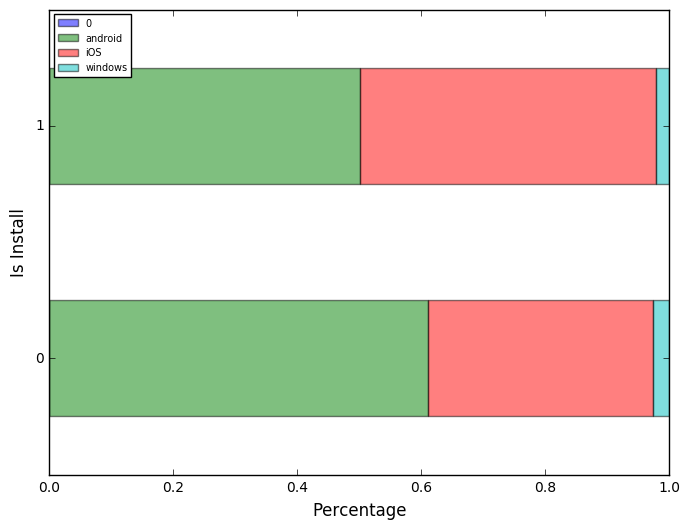

---------------------------------

-----------Feature: device_connection ----------------


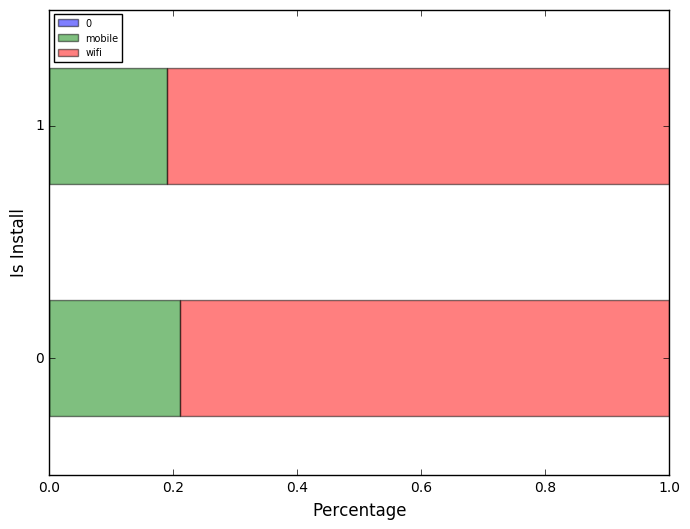

---------------------------------



('significant columns:', [])

In [5]:
def categotical_EDA(col, df):
    count = pd.crosstab(df['is_install'],df[col])
    count = count.iloc[:,0:]
    pcts = count.div(count.sum(1).astype(float),axis=0)
    g, p, dof, expctd = chi2_contingency(pcts.as_matrix())
    
    ax = pcts.plot(kind='barh',stacked=True, alpha=0.5, figsize=(8,6))
    ax.set_xlabel("Percentage", fontsize=12)
    ax.set_ylabel("Is Install", fontsize=12)
    ax.legend(loc=2,prop={'size':7})
    
    plt.show()
    return p

cat_cols = ['device_platform','device_connection']

p_lst = []
for col in cat_cols:
    print '-----------Feature:', col,'----------------'
    p = categotical_EDA(col,df_raw)
    p_lst.append(p)
    print '---------------------------------\n'
    
significant_cols = [col for col,p in zip(cat_cols,p_lst) if p<0.05]
'significant columns:', significant_cols

### 5. Continous variables

In [74]:
# continous_EDA function
def continous_EDA(col,df,dist_xlim=None,box_ylim=None):
    group0 = df[df['is_install']==0][col].dropna()
    group1 = df[df['is_install']==1][col].dropna()
    
    # T-test
    print 't-test'
    p = ttest_ind(group0, group1, axis=0, equal_var=False)

    # histogram of two groups
    print 'Distribution of two groups'
    fig, ax = plt.subplots()
    i = 0
    for a in [group0, group1]:
        g=sns.distplot(a, ax=ax, kde=False,label=str(i))
        i += 1
    g.set(xlim=(0, dist_xlim))
    ax.legend(loc=2,prop={'size':7})
    plt.show()
    
    # Box-plot
    print 'Box-plot'
    ax = sns.boxplot(x="is_install", y=col, data=df)
    ax.set(ylim=(0, box_ylim))
    plt.show()
    return  

-----------Feature: device_screen_height ----------------
t-test
Distribution of two groups


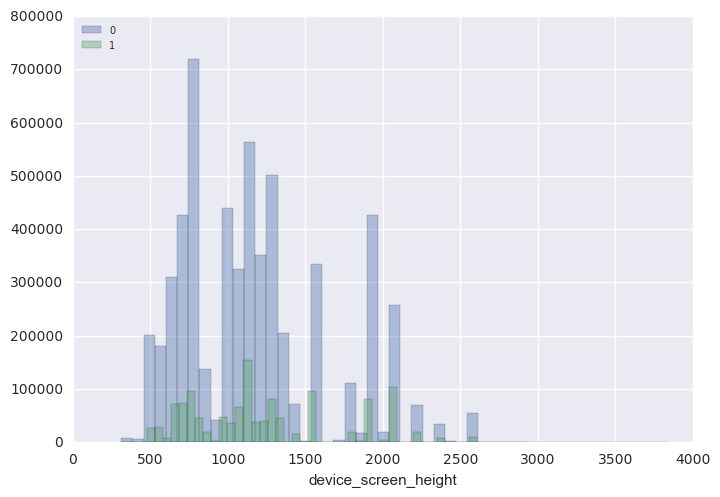

Box-plot


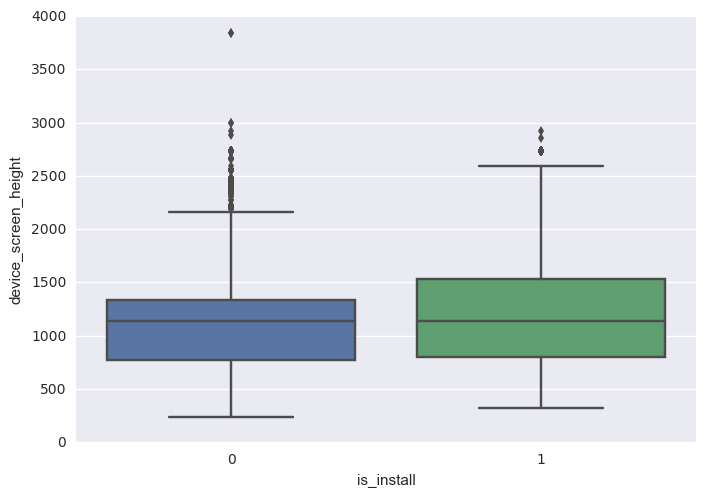

---------------------------------

-----------Feature: device_screen_width ----------------
t-test
Distribution of two groups


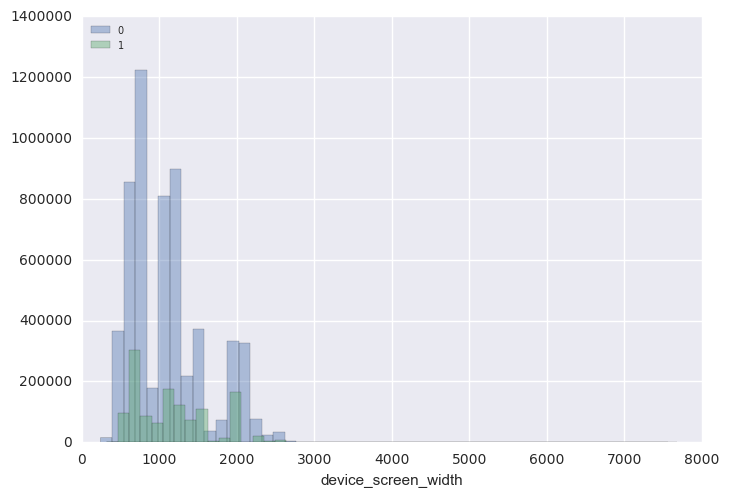

Box-plot


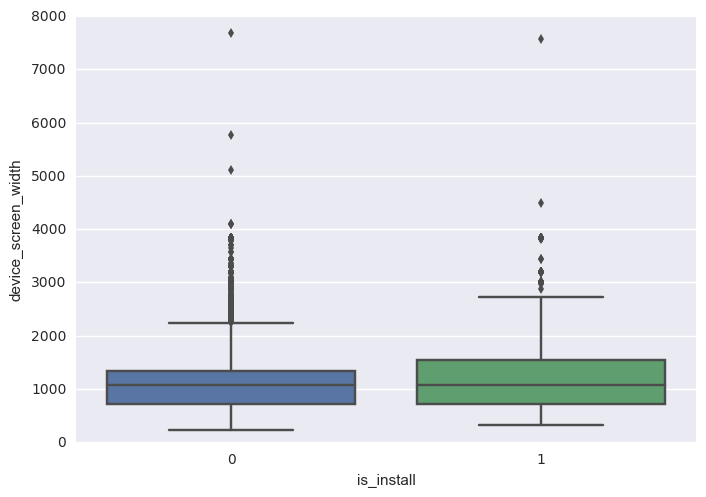

---------------------------------

-----------Feature: device_volume ----------------
t-test
Distribution of two groups


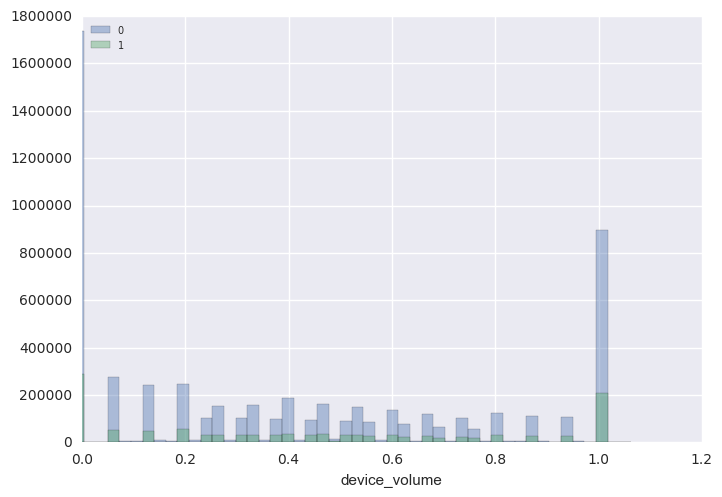

Box-plot


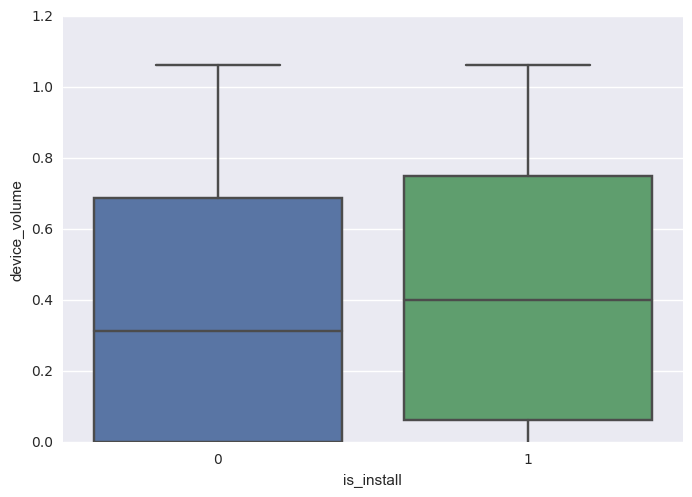

---------------------------------



('significant columns:', [])

In [75]:
cont_cols = ['device_screen_height','device_screen_width','device_volume']
p_lst = []
for col in cont_cols:
    print '-----------Feature:', col,'----------------'
    continous_EDA(col,df_raw)
    p_lst.append(p)
    print '---------------------------------\n'

significant_cols = [col for col,p in zip(cont_cols,p_lst) if p<0.05]
'significant columns:', significant_cols

-----------Feature: n_vungle_installs ----------------
t-test
Distribution of two groups


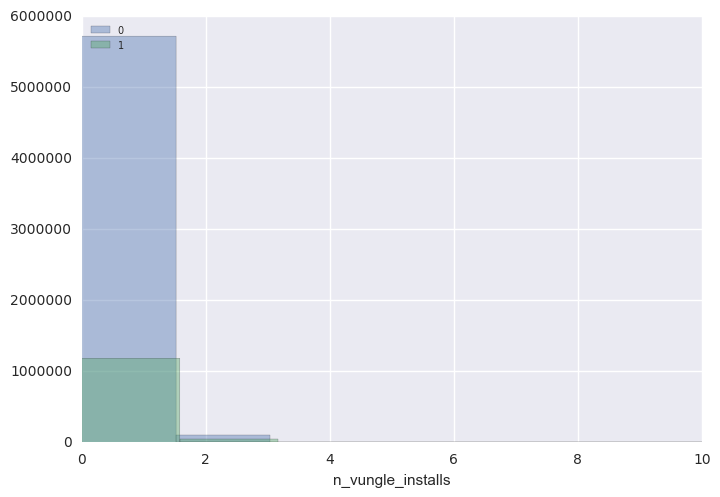

Box-plot


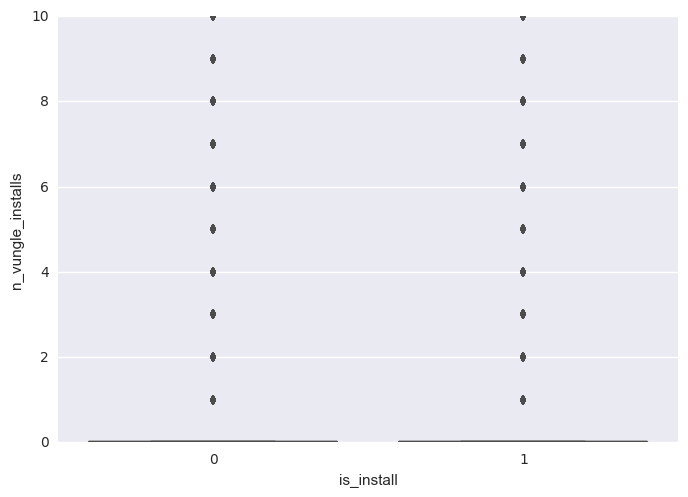

---------------------------------

-----------Feature: n_campaign_views ----------------
t-test
Distribution of two groups


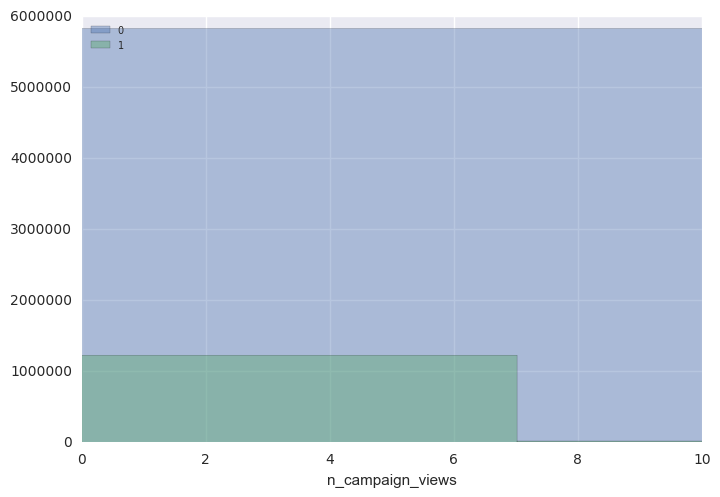

Box-plot


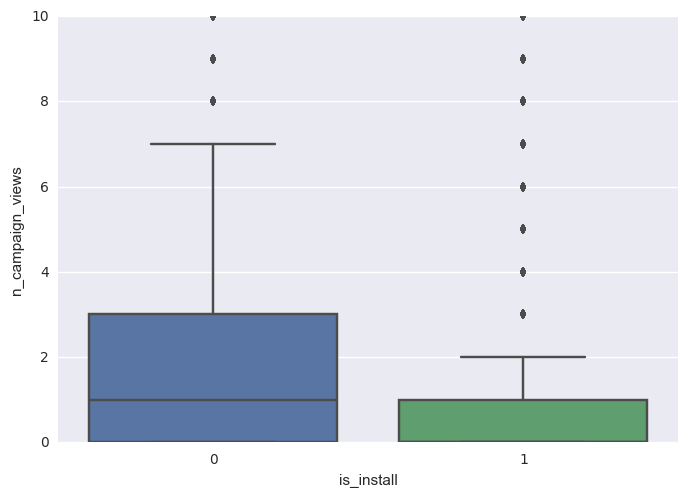

---------------------------------

[0.99929512024819145, 0.99929512024819145]


('significant columns:', [])

In [80]:
cont_cols = ['n_vungle_installs','n_campaign_views']
p_lst = []
for col in cont_cols:
    print '-----------Feature:', col,'----------------'
    continous_EDA(col,df_raw,10,10)
    p_lst.append(p)
    print '---------------------------------\n'

significant_cols = [col for col,p in zip(cont_cols,p_lst) if p<0.05]
print p_lst
'significant columns:', significant_cols